In [1]:
import os
import zipfile
import torch
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [4]:
# Extract dataset
zip_path = "intel-image-classification.zip"
extract_path = "intel-image-classification"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Confirm directory structure
print("Extracted folders:", os.listdir(extract_path))

Extracted folders: ['intel-image-classification']


In [10]:
# Path to train directory
data_dir = "intel-image-classification/intel-image-classification/seg_train/seg_train"

# Transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

# Load dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split into 80% train and 20% validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

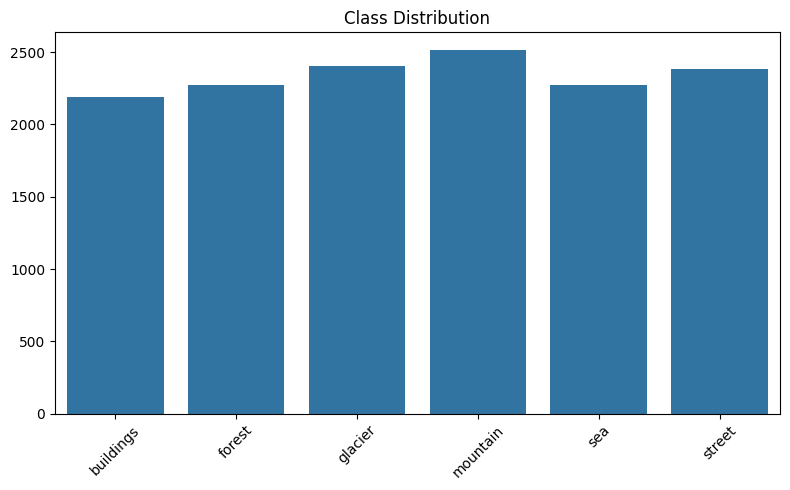

In [11]:
class_counts = [0] * len(full_dataset.classes)
for _, label in full_dataset:
    class_counts[label] += 1

plt.figure(figsize=(8, 5))
sns.barplot(x=full_dataset.classes, y=class_counts)
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet18 and adjust final layer
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(full_dataset.classes))
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


In [13]:
epochs = 5
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / total)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Accuracy: {val_accuracies[-1]:.4f}")

Epoch 1/5, Train Loss: 0.5099, Val Loss: 0.4879, Accuracy: 0.8340
Epoch 2/5, Train Loss: 0.3453, Val Loss: 0.4783, Accuracy: 0.8379
Epoch 3/5, Train Loss: 0.2966, Val Loss: 0.4333, Accuracy: 0.8425
Epoch 4/5, Train Loss: 0.2406, Val Loss: 0.3919, Accuracy: 0.8614
Epoch 5/5, Train Loss: 0.2162, Val Loss: 0.3828, Accuracy: 0.8842


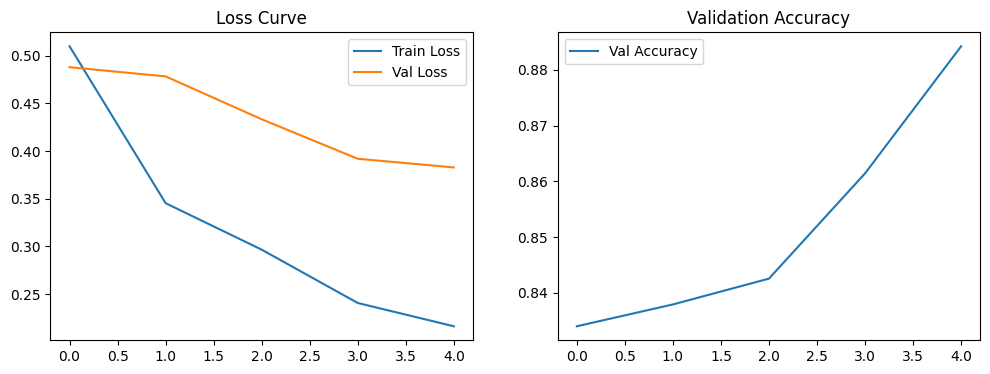

In [14]:
plt.figure(figsize=(12, 4))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Curve')

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.title('Validation Accuracy')

plt.show()

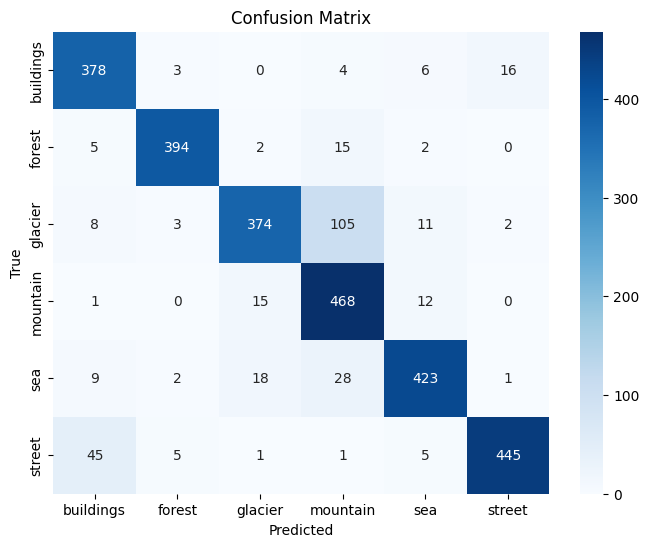

              precision    recall  f1-score   support

   buildings       0.85      0.93      0.89       407
      forest       0.97      0.94      0.96       418
     glacier       0.91      0.74      0.82       503
    mountain       0.75      0.94      0.84       496
         sea       0.92      0.88      0.90       481
      street       0.96      0.89      0.92       502

    accuracy                           0.88      2807
   macro avg       0.89      0.89      0.89      2807
weighted avg       0.89      0.88      0.88      2807



In [15]:
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=full_dataset.classes,
            yticklabels=full_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))